In [1]:
import geopandas as gpd
import json
import networkx as nx
import pandas as pd
import osmnx as ox
import pyarrow.feather as arrow

## Step 1: City Boundary
[Source](https://gis-pdx.opendata.arcgis.com/datasets/portland-administrative-sextants)

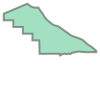

In [104]:
nw_pdx = gpd.read_file("Portland_Administrative_Sextants.geojson")
nw_pdx = (
    nw_pdx[nw_pdx['Sextant'] == 'Northwest']
    .to_crs(epsg = 4326)
    .geometry
    .unary_union
)
nw_pdx

In [114]:
nw_pdx_gdf = gpd.GeoSeries([nw_pdx]).__geo_interface__

In [115]:
with open("nw_pdx.geojson", "w") as f:
    json.dump(nw_pdx_gdf, f)

## Step 2, Option 1: Fetch OSMnx Links

In [109]:
graph = ox.graph_from_polygon(
    nw_pdx, 
    network_type = 'all', 
    simplify = False)

link_gdf = ox.graph_to_gdfs(graph, nodes = False, edges = True)
link_gdf.columns

Index(['osmid', 'name', 'highway', 'est_width', 'oneway', 'length', 'maxspeed',
       'service', 'lanes', 'access', 'width', 'bridge', 'ref', 'tunnel',
       'area', 'junction', 'geometry', 'u', 'v', 'key'],
      dtype='object')

In [110]:
def link_df_to_geojson(df, properties):
    """
    Author: Geoff Boeing:
    https://geoffboeing.com/2015/10/exporting-python-data-geojson/
    """
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"LineString",
                               "coordinates":[]}}
        feature["geometry"]["coordinates"] = [[x, y] for (x,y) in list(row["geometry"].coords)]
        for prop in properties:
            feature["properties"][prop] = row[prop]
        geojson["features"].append(feature)
    return geojson

In [111]:
link_prop = link_gdf.drop("geometry", axis = 1).columns.tolist()
link_geojson = link_df_to_geojson(link_gdf, link_prop)

In [112]:
with open("osmnx_link.geojson", "w") as f:
    json.dump(link_geojson, f)

## Step 2, Option 2: Read in OSMnx Links

In [3]:
osmnx_gdf = gpd.read_file("osmnx_link.geojson")

## Step 3: SharedStreets Extraction

See Dockerfile, then run
```
docker build -t shst .
docker run -it --rm -v ~/Documents/GitHub/osm-extract-validator:/usr/node/ shst:latest shst extract usr/node/nw_pdx.geojson --out=usr/node/shst.geojson --metadata --tile-hierarchy=8 --tiles
```

## Step 4, Option 1: Attribute Shared Streets

In [116]:
shst_gdf = gpd.read_file("shst.out.geojson")

In [117]:
no_dup_gdf = shst_gdf.drop_duplicates(
    subset = ['id', 'fromIntersectionId', 'toIntersectionId', 'forwardReferenceId', 'backReferenceId'])

In [118]:
def func(x, shst_link_df_list):
    df = pd.DataFrame(x.get("metadata").get("osmMetadata").get("waySections"))
    df["geometryId"] = x.get("metadata").get("geometryId")
    shst_link_df_list.append(df)

In [119]:
shst_link_df_list = []

no_dup_gdf.apply(
    lambda x: func(x, shst_link_df_list),
    axis = 1,
)

osm_link_df = pd.concat(shst_link_df_list)

In [125]:
osm_link_df.head()

,nodeIds,wayId,roadClass,oneWay,roundabout,link,name,geometryId
0,"[3775764800, 3775764803]",374186538,Other,False,False,False,,46b824ecd0e12698f5b6fac3647b8239
0,"[3775764800, 3775764802]",374186535,Other,False,False,False,,9ba554d9e3b5213226bb4a21e7f175c4
0,"[3775764822, 3775764809]",374186531,Other,False,False,False,,9c87810a90400a14ad0a82f4beffb7ea
1,"[3775764809, 3775764806]",374186546,Other,False,False,False,,9c87810a90400a14ad0a82f4beffb7ea
0,"[3775764803, 3775764822]",374186544,Other,False,False,False,,ec448b21e15a6f30d6565b96dc445850


In [139]:
osm_link_df.geometryId.value_counts()

6b3a365dcea689a06ed196f27c7be4dc    11
42ebc0daf3bbe843e3e02f00b907a47a     9
7588e51e4cae19bbc6d144c2763c8d4d     7
cc5ecf96d62420769baab4c296814623     7
eeb3f1424379b65e1a74c86a13f5aad1     7
                                    ..
c6ea6cf70d41b1968677fe6c7df4e07a     1
db042cf8eb66a81f07c3441a996bac01     1
677e5d6143121ea3510969128bdd4ace     1
d90163d804da8b930bd8b9663de43e5f     1
b29422e6da5bd9370cac684b7560e2aa     1
Name: geometryId, Length: 33408, dtype: int64

In [137]:
no_dup_gdf.head()

,id,fromIntersectionId,toIntersectionId,forwardReferenceId,backReferenceId,roadClass,metadata,geometry
0,46b824ecd0e12698f5b6fac3647b8239,b89a2b4a8f489a23b9b33e6428d928d3,510f6d4fe5ae8465789fcfab880264ed,77363b316a4a8270842db5e43bd98fc5,8486f1a1355fdd0ac8b9893f6d9a59e0,Other,"{'gisMetadata': [], 'geometryId': '46b824ecd0e...","LINESTRING (-122.68002 45.52143, -122.68014 45..."
1,9ba554d9e3b5213226bb4a21e7f175c4,b89a2b4a8f489a23b9b33e6428d928d3,a9b245c2a7d4067781972edf050a3255,c89e37636df1efd976085517818cbcd6,a49c1431a64caec88b99530862f8e400,Other,"{'gisMetadata': [], 'geometryId': '9ba554d9e3b...","LINESTRING (-122.68002 45.52143, -122.67998 45..."
2,9c87810a90400a14ad0a82f4beffb7ea,7f834a3241aada1590e41edcd3f9d3a0,abf792f4b2cc3b290d579c53c1a95e28,3b7ac8f9b33f79c5a57f534178d91340,78fcf95c29aac47e27662ed1959fccd7,Other,"{'gisMetadata': [], 'geometryId': '9c87810a904...","LINESTRING (-122.68005 45.52164, -122.68000 45..."
3,ec448b21e15a6f30d6565b96dc445850,510f6d4fe5ae8465789fcfab880264ed,7f834a3241aada1590e41edcd3f9d3a0,66fb67df2d80b7f6b971e1674302795e,e1660d691ce3a62ac447019e21b60f89,Other,"{'gisMetadata': [], 'geometryId': 'ec448b21e15...","LINESTRING (-122.68014 45.52147, -122.68005 45..."
4,ddebca518bb2006fe5e50c3b3e9b97f7,93c816f5e53f5a0e73d1f2418a1401da,5cd71ffcda7f0eac80d86cc8050a2b9f,4f86f9298a041b80742c67ba29a3cd70,dd36d8d2a054b832c1ef8641b2e69971,Other,"{'gisMetadata': [], 'geometryId': 'ddebca518bb...","LINESTRING (-122.68103 45.52177, -122.68113 45..."


# START HERE
Okay. So we've gotten it smaller with the single sextant
1. The osm_link_df is not unique. I'm not clear why. But we need to make it unique. 
2. Once that's fixed, try and build dataframe with unique shst link id, which is id, and then wayId array and nodeId turned into u, v
3. Then try and join with osmnx

In [138]:
no_dup_gdf.id.value_counts()

525348a4a5383ac05acb5d4229fa3b61    1
af614da26208349184439e9236e52260    1
5543f2bc0dcfd00126e0b8a8d595e05c    1
a27c2170d486b05ff3cd7dd3978f5b3d    1
7b940d3fa9d2d0179251d7b18306872b    1
                                   ..
932a10e4cc91d4fe6ed50f6877504ea3    1
43a9713574689349d49c134a486afc08    1
e9560344f210415a3824c72d5fd56059    1
961e68f3b9d027c7e9652a1d5b19808d    1
b29422e6da5bd9370cac684b7560e2aa    1
Name: id, Length: 33408, dtype: int64

In [127]:
shst_gdf = pd.merge(
    no_dup_gdf[['id','geometry']],
    osm_link_df.rename(columns={'geometryId':'id'}),
    how='left',
    on='id',
)

In [128]:
shst_gdf.head()

,id,geometry,nodeIds,wayId,roadClass,oneWay,roundabout,link,name
0,46b824ecd0e12698f5b6fac3647b8239,"LINESTRING (-122.68002 45.52143, -122.68014 45...","[3775764800, 3775764803]",374186538,Other,False,False,False,
1,9ba554d9e3b5213226bb4a21e7f175c4,"LINESTRING (-122.68002 45.52143, -122.67998 45...","[3775764800, 3775764802]",374186535,Other,False,False,False,
2,9c87810a90400a14ad0a82f4beffb7ea,"LINESTRING (-122.68005 45.52164, -122.68000 45...","[3775764822, 3775764809]",374186531,Other,False,False,False,
3,9c87810a90400a14ad0a82f4beffb7ea,"LINESTRING (-122.68005 45.52164, -122.68000 45...","[3775764809, 3775764806]",374186546,Other,False,False,False,
4,ec448b21e15a6f30d6565b96dc445850,"LINESTRING (-122.68014 45.52147, -122.68005 45...","[3775764803, 3775764822]",374186544,Other,False,False,False,


In [131]:
df = shst_gdf[['id', 'nodeIds']]

In [132]:
df_a = df.nodeIds.apply(pd.Series).add_prefix('node_id_')

,node_id0,node_id1,node_id2,node_id3,node_id4,node_id5,node_id6,node_id7,node_id8,node_id9,...,node_id319,node_id320,node_id321,node_id322,node_id323,node_id324,node_id325,node_id326,node_id327,node_id328
0,3775764800,3775764803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775764800,3775764802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3775764822,3775764809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3775764809,3775764806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3775764803,3775764822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df_b = df.join(df_a)
df_b.head()

,id,nodeIds,node_id0,node_id1,node_id2,node_id3,node_id4,node_id5,node_id6,node_id7,...,node_id319,node_id320,node_id321,node_id322,node_id323,node_id324,node_id325,node_id326,node_id327,node_id328
0,46b824ecd0e12698f5b6fac3647b8239,"[3775764800, 3775764803]",3775764800,3775764803,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9ba554d9e3b5213226bb4a21e7f175c4,"[3775764800, 3775764802]",3775764800,3775764802,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9c87810a90400a14ad0a82f4beffb7ea,"[3775764822, 3775764809]",3775764822,3775764809,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9c87810a90400a14ad0a82f4beffb7ea,"[3775764809, 3775764806]",3775764809,3775764806,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec448b21e15a6f30d6565b96dc445850,"[3775764803, 3775764822]",3775764803,3775764822,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
df_c = pd.wide_to_long(df_b, 'node_id', 'id', 'node_number')
df_c.head()

ValueError: the id variables need to uniquely identify each row

In [69]:
df_c = df_b.dropna(subset=['node_id_'])

In [71]:
df_d = df_c.reset_index()
df_d.head()

,geometryId,wayId,node_number,node_id_
0,37fef08b1d8c2222768618d9d62e4e3e,129973961,0,1433010017
1,37fef08b1d8c2222768618d9d62e4e3e,129973961,1,1433010013
2,07c55be670fa2b0f539503feb53986d2,129973968,0,1433010017
3,07c55be670fa2b0f539503feb53986d2,129973968,1,1433010035
4,07c55be670fa2b0f539503feb53986d2,129973968,2,1433010048


In [82]:
df_e = df_d.groupby(['geometryId', 'wayId'], as_index=False).last().rename(columns={'node_id_':'v'})
df_e.head()

,geometryId,wayId,node_number,v
0,00000cda270d767f7f4b75d65bf9899f,461420589,1,4569175515
1,00008635f74e92d43e3ab9fca5d5a516,35022886,11,410712397
2,0000a0570ceeeb0c291ba735c80e279b,420377425,1,40547236
3,00011d44836bdc10f9f4f8c57f291163,5519946,1,623462657
4,0001d302d582ce32de79670d0d5b43f8,172456408,3,1833619900


In [83]:
df_f = df_d.loc[df_d['node_number']==0].rename(columns={'node_id_':'u'})
df_f.head()

,geometryId,wayId,node_number,u
0,37fef08b1d8c2222768618d9d62e4e3e,129973961,0,1433010017
2,07c55be670fa2b0f539503feb53986d2,129973968,0,1433010017
7,3438b364cac82a7aa40cb765b1222a02,5513583,0,40413682
12,40fd13195db9e44db438732802be2756,5538912,0,40725476
15,702ce73bc0e1be0c404763202ffe26cf,59547017,0,738623933


In [78]:
df_g = df_e.append(df_f)
df_g.head()

,geometryId,wayId,node_number,node_id_
0,00000cda270d767f7f4b75d65bf9899f,461420589,1,4569175515
1,00008635f74e92d43e3ab9fca5d5a516,35022886,11,410712397
2,0000a0570ceeeb0c291ba735c80e279b,420377425,1,40547236
3,00011d44836bdc10f9f4f8c57f291163,5519946,1,623462657
4,0001d302d582ce32de79670d0d5b43f8,172456408,3,1833619900


In [81]:
df_h = df_g.sort_values(['geometryId', 'wayId', 'node_number']).reset_index(drop=True)
df_h.head()

,geometryId,wayId,node_number,node_id_
0,00000cda270d767f7f4b75d65bf9899f,461420589,0,4569175516
1,00000cda270d767f7f4b75d65bf9899f,461420589,1,4569175515
2,00008635f74e92d43e3ab9fca5d5a516,35022886,0,410395145
3,00008635f74e92d43e3ab9fca5d5a516,35022886,11,410712397
4,0000a0570ceeeb0c291ba735c80e279b,420377425,0,40520836


In [56]:
df_d = df_c.dropna(subset=['node_id_'])

In [59]:
shst_df = df_d.rename(columns={'node_id_':'node_id'})
shst_df.head()

,geometryId,wayId,node_number,node_id
0,37fef08b1d8c2222768618d9d62e4e3e,129973961,0,1433010017
1,37fef08b1d8c2222768618d9d62e4e3e,129973961,1,1433010013
329,07c55be670fa2b0f539503feb53986d2,129973968,0,1433010017
330,07c55be670fa2b0f539503feb53986d2,129973968,1,1433010035
331,07c55be670fa2b0f539503feb53986d2,129973968,2,1433010048


In [60]:
arrow.write_feather(shst_df, "shst.feather")

## Step 4, Option 2: Read in Attributed Shared Streets

In [61]:
shst_df = arrow.read_feather("shst.feather")

## Step 5: Compare Outcomes

In [62]:
shst_df.head()

,geometryId,wayId,node_number,node_id
0,37fef08b1d8c2222768618d9d62e4e3e,129973961,0,1433010017
1,37fef08b1d8c2222768618d9d62e4e3e,129973961,1,1433010013
2,07c55be670fa2b0f539503feb53986d2,129973968,0,1433010017
3,07c55be670fa2b0f539503feb53986d2,129973968,1,1433010035
4,07c55be670fa2b0f539503feb53986d2,129973968,2,1433010048


In [65]:
# this is from OSMnx
osmnx_gdf.columns

Index(['osmid', 'highway', 'oneway', 'length', 'lanes', 'maxspeed', 'name',
       'est_width', 'access', 'width', 'ref', 'service', 'bridge', 'tunnel',
       'junction', 'area', 'landuse', 'u', 'v', 'key', 'geometry'],
      dtype='object')

In [66]:
osmnx_gdf[['u', 'v', 'key']].head()

,u,v,key
0,4581752832,2005438068,0
1,4581752832,4581752833,0
2,4581752833,4581752832,0
3,4581752833,4581752834,0
4,4581752834,4581752831,0


In [ ]:
# this is from shSt
osm_link_df.columns

In [ ]:
# Let's try to join on U and nodeIds or wayId and something